Importamos lo necesario para el Script.

In [1]:
#CIL
from cil.io import NikonDataReader
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector, Binner, AbsorptionTransmissionConverter
from cil.optimisation.functions import IndicatorBox
from cil.optimisation.algorithms import CGLS, SIRT, PDHG
from cil.utilities.display import show2D, show1D, show_geometry
from cil.utilities.jupyter import islicer
from cil.optimisation.operators import IdentityOperator
from cil.optimisation.functions import L2NormSquared, L1Norm
#from cil.utilities import dataexample

# TIGRE
from cil.recon import FDK as FDKTigre
from cil.plugins.tigre import ProjectionOperator as ProjectionOperatorTigre
from cil.plugins.tigre import FBP as FBPTigre

# Astra
from cil.plugins.astra.processors import FBP as FBPAstra
from cil.plugins.astra.operators import ProjectionOperator as ProjectionOperatorAstra

# Plugins
from cil.plugins import TomoPhantom

# Otros
import os
import numpy as np
import matplotlib.pyplot as plt
import logging

import pydicom
from pydicom.dataset import Dataset, FileDataset
import datetime

Guardamos la ruta donde se encuentra nuestro archivo `xtekct` del tomografo Nikon.

In [2]:
filename = "Cili\CS180.xtekct"

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\TalentPC\AppData\Local\Temp\ipykernel_12708\3574950331.py:1: SyntaxWarning: invalid escape sequence '\C'
  filename = "Cili\CS180.xtekct"


In [3]:
import logging
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

Para que se puedan leer los datos de entrada, el archivo `xteckt` debe de estar en la misma carpeta que las proyecciones. Para este caso está en la misma carpeta que las 180 imagenes .Tif del cilindro.

In [4]:
data_in = NikonDataReader(file_name=filename).read()

In [5]:
print(data_in)

Number of dimensions: 3
Shape: (180, 499, 500)
Axis labels: ('angle', 'vertical', 'horizontal')



In [6]:
# print the geometry data associated with the data
print(data_in.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [  0.    , -87.9998,   0.    ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  -0.    , 1019.0002,    0.    ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [500 499]
	Pixel size: [0.1 0.1]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 180
	Angles 0-9 in degrees: [174.20728, 172.20728, 170.20726, 168.20724, 166.20723, 164.20721,
 162.2072 , 160.20718, 158.20718, 156.20717]
	Angles 170-179 in degrees: [-165.79492, -167.79495, -169.79495, -171.79498, -173.79498, -175.79501,
 -177.79501, -179.79501, -181.79504, -183.79504]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


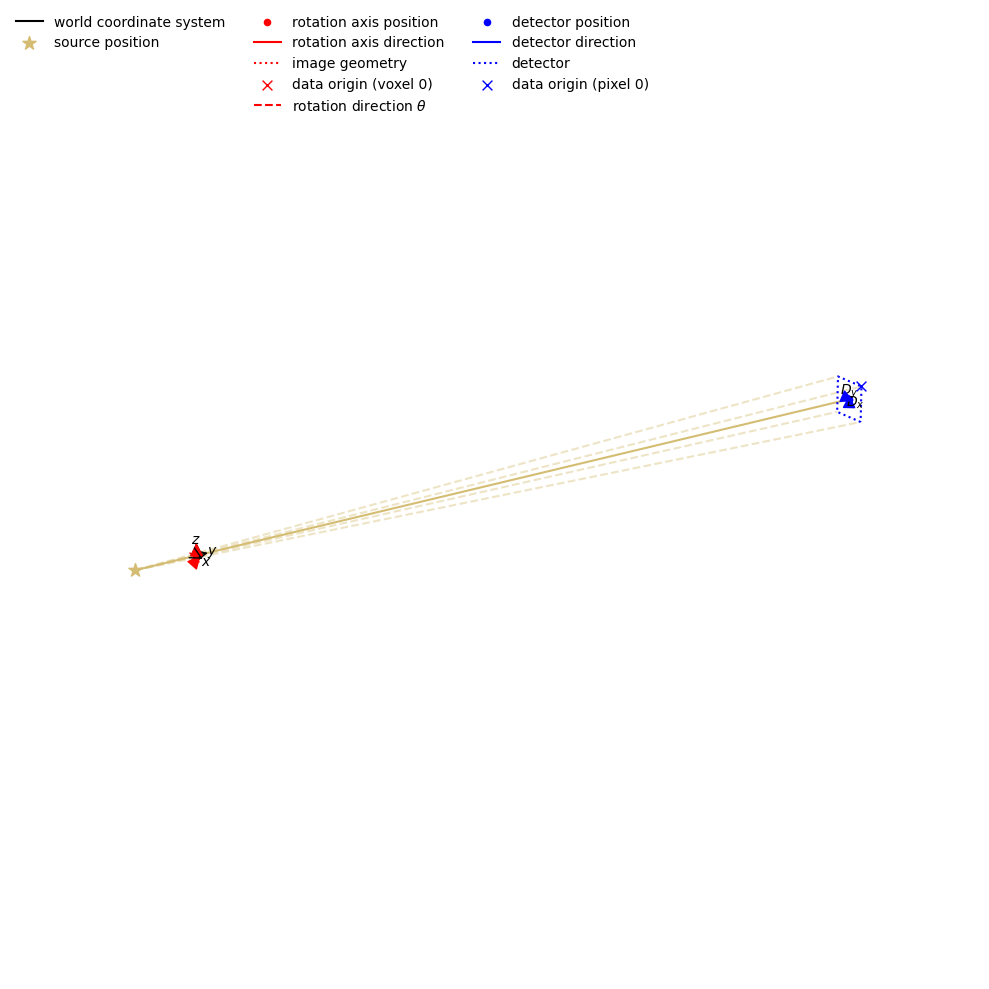

In [7]:
# display the geometry
show_geometry(data_in.geometry, elevation=20, azimuthal=- 35, view_distance=10, figsize=(10, 10), fontsize=10)

In [8]:
islicer(data_in, direction='angle',size=10, origin='upper')

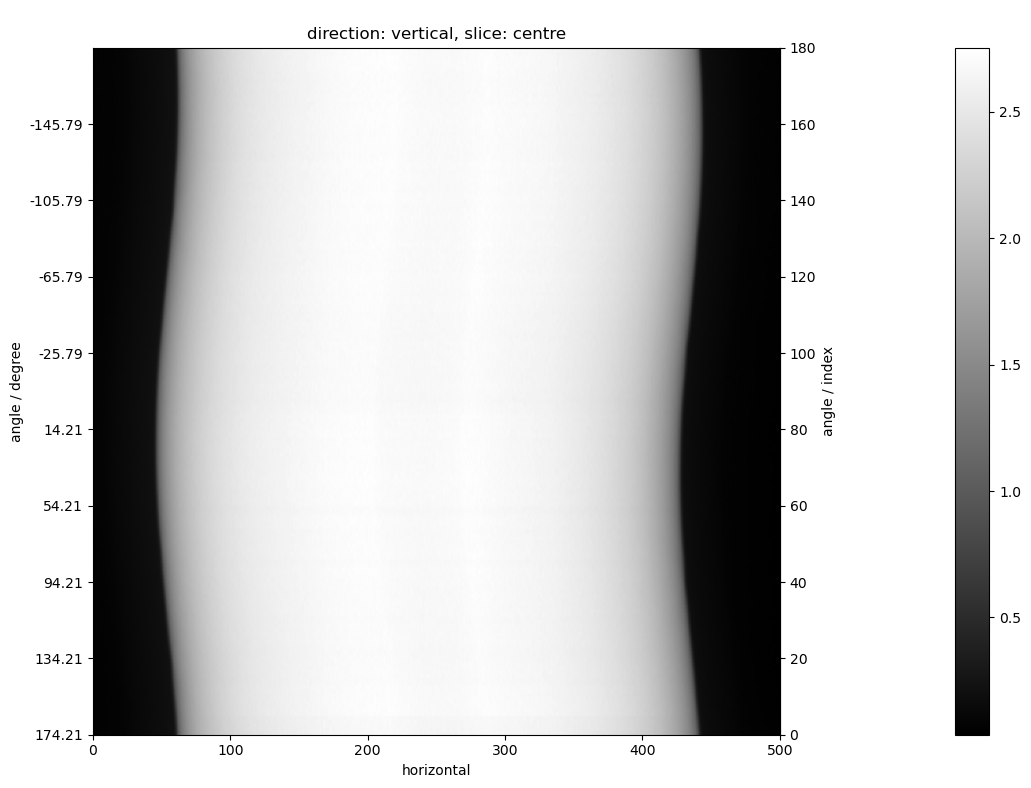

In [8]:
# calculate the absorption data using the Beer–Lambert law
data_absorption = TransmissionAbsorptionConverter()(data_in)

# show the centre slice using show2D
show2D(data_absorption, slice_list=('vertical', 'centre'))

In [9]:
ag = NikonDataReader(file_name=filename).get_geometry()
ig = ag.get_ImageGeometry()

# FDK TIGRE

In [10]:
data_absorption.reorder(order='tigre')
data_centred = CentreOfRotationCorrector.image_sharpness(backend='tigre', search_range=100, tolerance=0.1)(data_absorption)

INFO:cil.processors.CofR_image_sharpness:evaluated 11 points
INFO:cil.processors.CofR_image_sharpness:Centre of rotation correction found using image_sharpness
INFO:cil.processors.CofR_image_sharpness:backend FBP/FDK tigre
INFO:cil.processors.CofR_image_sharpness:Calculated from slice: centre
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 5.324566 pixels
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = 0.042327 units at the object
INFO:cil.processors.CofR_image_sharpness:Return new dataset with centred geometry


In [11]:
ag2 = data_centred.geometry
ig2 = ag2.get_ImageGeometry()

In [12]:
# reorder the data for the `tigre` backend
#data_absorption.reorder(order='tigre')

# create the FDK reconstructor
fdk =  FDKTigre(data_centred, ig2)

# run the reconstructor
recon = fdk.run()

FDK recon

Input Data:
	angle: 180
	vertical: 499
	horizontal: 500

Reconstruction Volume:
	vertical: 499
	horizontal_y: 500
	horizontal_x: 500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 10
	Filter_inplace: False



In [14]:
# visualise the 3D reconstructed volume
islicer(recon, direction='vertical', size=10, cmap="gray") # change to 'horizontal_y' or 'horizontal_x' to view the data in other directions
#show2D(recon, slice_list=[('vertical',250), ('horizontal_x', 250)], fix_range=(-0.01, 0.1))

In [ ]:
# Puedo mirar cada uno de las rebanadas en FDK
for i in range(recon.array.shape[0]):
    plt.imshow(recon.array[i], cmap='gray')
    plt.title(f'Slice {i}')
    plt.show()

In [24]:
"""
Rango de valores (windowing/leveling), es decir, conocer los valores
de la imagen si están fuera del rango visible para la visualización.
En este caso, me ayudan a conocer los parametros de los pixeles
para que se visualicen correctamente en escala de grises.
"""
print(np.min(recon.array), np.max(recon.array))

-0.25394717 1.9095713


### Obtener los archivos DICOM a partir de la reconstrucción de FDK

In [25]:
def create_dicom_from_volume(volume, output_folder, min_value, max_value):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Escalar los valores de los píxeles al rango de 0 a 65535
    volume_scaled = np.clip(volume, min_value, max_value)  # Limitar los valores al rango especificado
    volume_scaled = ((volume_scaled - min_value) / (max_value - min_value) * 65535).astype(np.uint16)

    # Crear el archivo DICOM para cada corte
    for i in range(volume_scaled.shape[0]):
        # Crear un Dataset DICOM en blanco
        file_meta = pydicom.Dataset()
        ds = FileDataset(None, {}, file_meta=file_meta, preamble=b"\0" * 128)

        # Añadir información esencial
        ds.PatientName = "Cilindro"
        ds.PatientID = "1"
        ds.is_little_endian = True
        ds.is_implicit_VR = True

        # Añadir fecha y hora
        dt = datetime.datetime.now()
        ds.ContentDate = dt.strftime('%Y%m%d')
        ds.ContentTime = dt.strftime('%H%M%S.%f')

        # Especificar dimensiones del volumen
        ds.SliceThickness = 1.0
        ds.PixelSpacing = [1.0, 1.0]
        ds.Rows, ds.Columns = volume_scaled.shape[1], volume_scaled.shape[2]

        # Especificar tipo de datos
        ds.SamplesPerPixel = 1
        ds.PhotometricInterpretation = "MONOCHROME2"
        ds.BitsAllocated = 16
        ds.BitsStored = 16
        ds.HighBit = 15
        ds.PixelRepresentation = 1
        ds.Modality = "CT"
        ds.SeriesInstanceUID = pydicom.uid.generate_uid()

        # Asignar los datos de la imagen
        ds.PixelData = volume_scaled[i].tobytes()

        # Guardar cada corte como un archivo DICOM individual
        dicom_filename = os.path.join(output_folder, f"slice_{i:03d}.dcm")
        ds.save_as(dicom_filename)
        print(f"Guardado: {dicom_filename}")

# Crear una carpeta para almacenar los archivos DICOM
output_folder = "DICOM"

# Valores mínimos y máximos conocidos de la reconstrucción
min_value = -0.25394717
max_value = 1.9095713

# Llamar a la función con el volumen reconstruido escalado y el rango adecuado
create_dicom_from_volume(recon.array, output_folder, min_value, max_value)


Guardado: dicom_output\slice_000.dcm
Guardado: dicom_output\slice_001.dcm
Guardado: dicom_output\slice_002.dcm
Guardado: dicom_output\slice_003.dcm
Guardado: dicom_output\slice_004.dcm
Guardado: dicom_output\slice_005.dcm
Guardado: dicom_output\slice_006.dcm
Guardado: dicom_output\slice_007.dcm
Guardado: dicom_output\slice_008.dcm
Guardado: dicom_output\slice_009.dcm
Guardado: dicom_output\slice_010.dcm
Guardado: dicom_output\slice_011.dcm
Guardado: dicom_output\slice_012.dcm
Guardado: dicom_output\slice_013.dcm
Guardado: dicom_output\slice_014.dcm
Guardado: dicom_output\slice_015.dcm
Guardado: dicom_output\slice_016.dcm
Guardado: dicom_output\slice_017.dcm
Guardado: dicom_output\slice_018.dcm
Guardado: dicom_output\slice_019.dcm
Guardado: dicom_output\slice_020.dcm
Guardado: dicom_output\slice_021.dcm
Guardado: dicom_output\slice_022.dcm
Guardado: dicom_output\slice_023.dcm
Guardado: dicom_output\slice_024.dcm
Guardado: dicom_output\slice_025.dcm
Guardado: dicom_output\slice_026.dcm
G

Guardado: dicom_output\slice_054.dcm
Guardado: dicom_output\slice_055.dcm
Guardado: dicom_output\slice_056.dcm
Guardado: dicom_output\slice_057.dcm
Guardado: dicom_output\slice_058.dcm
Guardado: dicom_output\slice_059.dcm
Guardado: dicom_output\slice_060.dcm
Guardado: dicom_output\slice_061.dcm
Guardado: dicom_output\slice_062.dcm
Guardado: dicom_output\slice_063.dcm
Guardado: dicom_output\slice_064.dcm
Guardado: dicom_output\slice_065.dcm
Guardado: dicom_output\slice_066.dcm
Guardado: dicom_output\slice_067.dcm
Guardado: dicom_output\slice_068.dcm
Guardado: dicom_output\slice_069.dcm
Guardado: dicom_output\slice_070.dcm
Guardado: dicom_output\slice_071.dcm
Guardado: dicom_output\slice_072.dcm
Guardado: dicom_output\slice_073.dcm
Guardado: dicom_output\slice_074.dcm
Guardado: dicom_output\slice_075.dcm
Guardado: dicom_output\slice_076.dcm
Guardado: dicom_output\slice_077.dcm
Guardado: dicom_output\slice_078.dcm
Guardado: dicom_output\slice_079.dcm
Guardado: dicom_output\slice_080.dcm
G

Guardado: dicom_output\slice_106.dcm
Guardado: dicom_output\slice_107.dcm
Guardado: dicom_output\slice_108.dcm
Guardado: dicom_output\slice_109.dcm
Guardado: dicom_output\slice_110.dcm
Guardado: dicom_output\slice_111.dcm
Guardado: dicom_output\slice_112.dcm
Guardado: dicom_output\slice_113.dcm
Guardado: dicom_output\slice_114.dcm
Guardado: dicom_output\slice_115.dcm
Guardado: dicom_output\slice_116.dcm
Guardado: dicom_output\slice_117.dcm
Guardado: dicom_output\slice_118.dcm
Guardado: dicom_output\slice_119.dcm
Guardado: dicom_output\slice_120.dcm
Guardado: dicom_output\slice_121.dcm
Guardado: dicom_output\slice_122.dcm
Guardado: dicom_output\slice_123.dcm
Guardado: dicom_output\slice_124.dcm
Guardado: dicom_output\slice_125.dcm
Guardado: dicom_output\slice_126.dcm
Guardado: dicom_output\slice_127.dcm
Guardado: dicom_output\slice_128.dcm
Guardado: dicom_output\slice_129.dcm
Guardado: dicom_output\slice_130.dcm
Guardado: dicom_output\slice_131.dcm
Guardado: dicom_output\slice_132.dcm
G

Guardado: dicom_output\slice_160.dcm
Guardado: dicom_output\slice_161.dcm
Guardado: dicom_output\slice_162.dcm
Guardado: dicom_output\slice_163.dcm
Guardado: dicom_output\slice_164.dcm
Guardado: dicom_output\slice_165.dcm
Guardado: dicom_output\slice_166.dcm
Guardado: dicom_output\slice_167.dcm
Guardado: dicom_output\slice_168.dcm
Guardado: dicom_output\slice_169.dcm
Guardado: dicom_output\slice_170.dcm
Guardado: dicom_output\slice_171.dcm
Guardado: dicom_output\slice_172.dcm
Guardado: dicom_output\slice_173.dcm
Guardado: dicom_output\slice_174.dcm
Guardado: dicom_output\slice_175.dcm
Guardado: dicom_output\slice_176.dcm
Guardado: dicom_output\slice_177.dcm
Guardado: dicom_output\slice_178.dcm
Guardado: dicom_output\slice_179.dcm
Guardado: dicom_output\slice_180.dcm
Guardado: dicom_output\slice_181.dcm
Guardado: dicom_output\slice_182.dcm
Guardado: dicom_output\slice_183.dcm
Guardado: dicom_output\slice_184.dcm
Guardado: dicom_output\slice_185.dcm
Guardado: dicom_output\slice_186.dcm
G

Guardado: dicom_output\slice_210.dcm
Guardado: dicom_output\slice_211.dcm
Guardado: dicom_output\slice_212.dcm
Guardado: dicom_output\slice_213.dcm
Guardado: dicom_output\slice_214.dcm
Guardado: dicom_output\slice_215.dcm
Guardado: dicom_output\slice_216.dcm
Guardado: dicom_output\slice_217.dcm
Guardado: dicom_output\slice_218.dcm
Guardado: dicom_output\slice_219.dcm
Guardado: dicom_output\slice_220.dcm
Guardado: dicom_output\slice_221.dcm
Guardado: dicom_output\slice_222.dcm
Guardado: dicom_output\slice_223.dcm
Guardado: dicom_output\slice_224.dcm
Guardado: dicom_output\slice_225.dcm
Guardado: dicom_output\slice_226.dcm
Guardado: dicom_output\slice_227.dcm
Guardado: dicom_output\slice_228.dcm
Guardado: dicom_output\slice_229.dcm
Guardado: dicom_output\slice_230.dcm
Guardado: dicom_output\slice_231.dcm
Guardado: dicom_output\slice_232.dcm
Guardado: dicom_output\slice_233.dcm
Guardado: dicom_output\slice_234.dcm
Guardado: dicom_output\slice_235.dcm
Guardado: dicom_output\slice_236.dcm
G

Guardado: dicom_output\slice_265.dcm
Guardado: dicom_output\slice_266.dcm
Guardado: dicom_output\slice_267.dcm
Guardado: dicom_output\slice_268.dcm
Guardado: dicom_output\slice_269.dcm
Guardado: dicom_output\slice_270.dcm
Guardado: dicom_output\slice_271.dcm
Guardado: dicom_output\slice_272.dcm
Guardado: dicom_output\slice_273.dcm
Guardado: dicom_output\slice_274.dcm
Guardado: dicom_output\slice_275.dcm
Guardado: dicom_output\slice_276.dcm
Guardado: dicom_output\slice_277.dcm
Guardado: dicom_output\slice_278.dcm
Guardado: dicom_output\slice_279.dcm
Guardado: dicom_output\slice_280.dcm
Guardado: dicom_output\slice_281.dcm
Guardado: dicom_output\slice_282.dcm
Guardado: dicom_output\slice_283.dcm
Guardado: dicom_output\slice_284.dcm
Guardado: dicom_output\slice_285.dcm
Guardado: dicom_output\slice_286.dcm
Guardado: dicom_output\slice_287.dcm
Guardado: dicom_output\slice_288.dcm
Guardado: dicom_output\slice_289.dcm
Guardado: dicom_output\slice_290.dcm
Guardado: dicom_output\slice_291.dcm
G

Guardado: dicom_output\slice_319.dcm
Guardado: dicom_output\slice_320.dcm
Guardado: dicom_output\slice_321.dcm
Guardado: dicom_output\slice_322.dcm
Guardado: dicom_output\slice_323.dcm
Guardado: dicom_output\slice_324.dcm
Guardado: dicom_output\slice_325.dcm
Guardado: dicom_output\slice_326.dcm
Guardado: dicom_output\slice_327.dcm
Guardado: dicom_output\slice_328.dcm
Guardado: dicom_output\slice_329.dcm
Guardado: dicom_output\slice_330.dcm
Guardado: dicom_output\slice_331.dcm
Guardado: dicom_output\slice_332.dcm
Guardado: dicom_output\slice_333.dcm
Guardado: dicom_output\slice_334.dcm
Guardado: dicom_output\slice_335.dcm
Guardado: dicom_output\slice_336.dcm
Guardado: dicom_output\slice_337.dcm
Guardado: dicom_output\slice_338.dcm
Guardado: dicom_output\slice_339.dcm
Guardado: dicom_output\slice_340.dcm
Guardado: dicom_output\slice_341.dcm
Guardado: dicom_output\slice_342.dcm
Guardado: dicom_output\slice_343.dcm
Guardado: dicom_output\slice_344.dcm
Guardado: dicom_output\slice_345.dcm
G

Guardado: dicom_output\slice_375.dcm
Guardado: dicom_output\slice_376.dcm
Guardado: dicom_output\slice_377.dcm
Guardado: dicom_output\slice_378.dcm
Guardado: dicom_output\slice_379.dcm
Guardado: dicom_output\slice_380.dcm
Guardado: dicom_output\slice_381.dcm
Guardado: dicom_output\slice_382.dcm
Guardado: dicom_output\slice_383.dcm
Guardado: dicom_output\slice_384.dcm
Guardado: dicom_output\slice_385.dcm
Guardado: dicom_output\slice_386.dcm
Guardado: dicom_output\slice_387.dcm
Guardado: dicom_output\slice_388.dcm
Guardado: dicom_output\slice_389.dcm
Guardado: dicom_output\slice_390.dcm
Guardado: dicom_output\slice_391.dcm
Guardado: dicom_output\slice_392.dcm
Guardado: dicom_output\slice_393.dcm
Guardado: dicom_output\slice_394.dcm
Guardado: dicom_output\slice_395.dcm
Guardado: dicom_output\slice_396.dcm
Guardado: dicom_output\slice_397.dcm
Guardado: dicom_output\slice_398.dcm
Guardado: dicom_output\slice_399.dcm
Guardado: dicom_output\slice_400.dcm
Guardado: dicom_output\slice_401.dcm
G

Guardado: dicom_output\slice_426.dcm
Guardado: dicom_output\slice_427.dcm
Guardado: dicom_output\slice_428.dcm
Guardado: dicom_output\slice_429.dcm
Guardado: dicom_output\slice_430.dcm
Guardado: dicom_output\slice_431.dcm
Guardado: dicom_output\slice_432.dcm
Guardado: dicom_output\slice_433.dcm
Guardado: dicom_output\slice_434.dcm
Guardado: dicom_output\slice_435.dcm
Guardado: dicom_output\slice_436.dcm
Guardado: dicom_output\slice_437.dcm
Guardado: dicom_output\slice_438.dcm
Guardado: dicom_output\slice_439.dcm
Guardado: dicom_output\slice_440.dcm
Guardado: dicom_output\slice_441.dcm
Guardado: dicom_output\slice_442.dcm
Guardado: dicom_output\slice_443.dcm
Guardado: dicom_output\slice_444.dcm
Guardado: dicom_output\slice_445.dcm
Guardado: dicom_output\slice_446.dcm
Guardado: dicom_output\slice_447.dcm
Guardado: dicom_output\slice_448.dcm
Guardado: dicom_output\slice_449.dcm
Guardado: dicom_output\slice_450.dcm
Guardado: dicom_output\slice_451.dcm
Guardado: dicom_output\slice_452.dcm
G

Guardado: dicom_output\slice_474.dcm
Guardado: dicom_output\slice_475.dcm
Guardado: dicom_output\slice_476.dcm
Guardado: dicom_output\slice_477.dcm
Guardado: dicom_output\slice_478.dcm
Guardado: dicom_output\slice_479.dcm
Guardado: dicom_output\slice_480.dcm
Guardado: dicom_output\slice_481.dcm
Guardado: dicom_output\slice_482.dcm
Guardado: dicom_output\slice_483.dcm
Guardado: dicom_output\slice_484.dcm
Guardado: dicom_output\slice_485.dcm
Guardado: dicom_output\slice_486.dcm
Guardado: dicom_output\slice_487.dcm
Guardado: dicom_output\slice_488.dcm
Guardado: dicom_output\slice_489.dcm
Guardado: dicom_output\slice_490.dcm
Guardado: dicom_output\slice_491.dcm
Guardado: dicom_output\slice_492.dcm
Guardado: dicom_output\slice_493.dcm
Guardado: dicom_output\slice_494.dcm
Guardado: dicom_output\slice_495.dcm
Guardado: dicom_output\slice_496.dcm
Guardado: dicom_output\slice_497.dcm
Guardado: dicom_output\slice_498.dcm
